In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from mpl_toolkits.basemap import Basemap
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from yellowbrick.cluster import silhouette_visualizer
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("earthquakes_2023_global.csv")
df.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2023-01-01T00:49:25.294Z,52.0999,178.5218,82.770,3.10,ml,14.0,139.0,0.8700,0.18,...,2023-03-11T22:51:52.040Z,"Rat Islands, Aleutian Islands, Alaska",earthquake,8.46,21.213,0.097,14.0,reviewed,us,us
1,2023-01-01T01:41:43.755Z,7.1397,126.7380,79.194,4.50,mb,32.0,104.0,1.1520,0.47,...,2023-03-11T22:51:45.040Z,"23 km ESE of Manay, Philippines",earthquake,5.51,7.445,0.083,43.0,reviewed,us,us
2,2023-01-01T03:29:31.070Z,19.1631,-66.5251,24.000,3.93,md,23.0,246.0,0.8479,0.22,...,2023-03-11T22:51:29.040Z,Puerto Rico region,earthquake,0.91,15.950,0.090,16.0,reviewed,pr,pr
3,2023-01-01T04:09:32.814Z,-4.7803,102.7675,63.787,4.30,mb,17.0,187.0,0.4570,0.51,...,2023-03-11T22:51:45.040Z,"99 km SSW of Pagar Alam, Indonesia",earthquake,10.25,6.579,0.238,5.0,reviewed,us,us
4,2023-01-01T04:29:13.793Z,53.3965,-166.9417,10.000,3.00,ml,19.0,190.0,0.4000,0.31,...,2023-03-11T22:51:38.040Z,"59 km SSW of Unalaska, Alaska",earthquake,1.41,1.999,0.085,18.0,reviewed,us,us


In [3]:
#Construct new dataframe
newdf = df[['latitude','longitude','depth','mag']]
#Check null value
newdf.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
dtype: int64

In [4]:
newdf.shape

(26642, 4)

In [5]:
from sklearn.preprocessing import StandardScaler

# Select only the columns to normalize
columns_to_normalize = ['mag', 'depth']

# Fit the scaler on the selected columns
scaler = StandardScaler().fit(newdf[columns_to_normalize])

# Transform the selected columns
newdf_norm = newdf.copy()
newdf_norm[columns_to_normalize] = scaler.transform(newdf[columns_to_normalize])

# Combine with untouched columns
for col in ['latitude', 'longitude']:
    newdf_norm[col] = newdf[col]

In [6]:
newdf_norm

,latitude,longitude,depth,mag
0,52.0999,178.5218,0.130856,-1.142229
1,7.1397,126.7380,0.100229,0.620091
2,19.1631,-66.5251,-0.372483,-0.097425
3,-4.7803,102.7675,-0.031725,0.368331
4,53.3965,-166.9417,-0.492387,-1.268109
...,...,...,...,...
26637,-6.9527,154.9829,-0.492387,1.501251
26638,32.3262,141.7386,-0.492387,1.375371
26639,-7.2411,68.0663,-0.492387,1.375371
26640,-19.1602,169.0428,0.734606,0.871851


## K-Means

#### Elbow Method

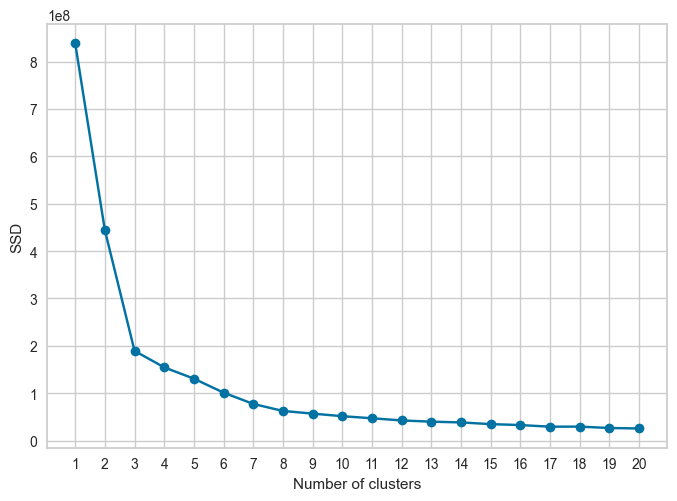

In [7]:
max_k = 20
ssd = []
for i in range(1, max_k+1):
    km_elbow = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km_elbow.fit(newdf)
    ssd.append(km_elbow.inertia_) #Sum of squared distances of samples to their closest cluster center

# plot
plt.plot(range(1, max_k+1), ssd, marker='o')
plt.xticks(range(1, max_k+1))
plt.xlabel('Number of clusters')
plt.ylabel('SSD')
plt.show()

In [8]:
from sklearn.cluster import KMeans

# set number of cluster to get labels
km = KMeans(n_clusters = 2, random_state=1)
km.fit(newdf_norm)

KMeans(n_clusters=3, random_state=1)

In [9]:
print(km.labels_)

[1 1 0 ... 1 1 1]


In [10]:
# Merge cluster set
df_clustered = newdf.copy()
df_clustered['label']=km.labels_
df_clustered

,latitude,longitude,depth,mag,label
0,52.0999,178.5218,82.770,3.10,1
1,7.1397,126.7380,79.194,4.50,1
2,19.1631,-66.5251,24.000,3.93,0
3,-4.7803,102.7675,63.787,4.30,1
4,53.3965,-166.9417,10.000,3.00,2
...,...,...,...,...,...
26637,-6.9527,154.9829,10.000,5.20,1
26638,32.3262,141.7386,10.000,5.10,1
26639,-7.2411,68.0663,10.000,5.10,1
26640,-19.1602,169.0428,153.264,4.70,1


In [11]:
label_counts = df_clustered['label'].value_counts()

# Display the counts
print("Count of label 0:", label_counts.get(0, 0))
print("Count of label 1:", label_counts.get(1, 0))
# print("Count of label 2:", label_counts.get(2, 0))

Count of label 0: 6495
Count of label 1: 11727


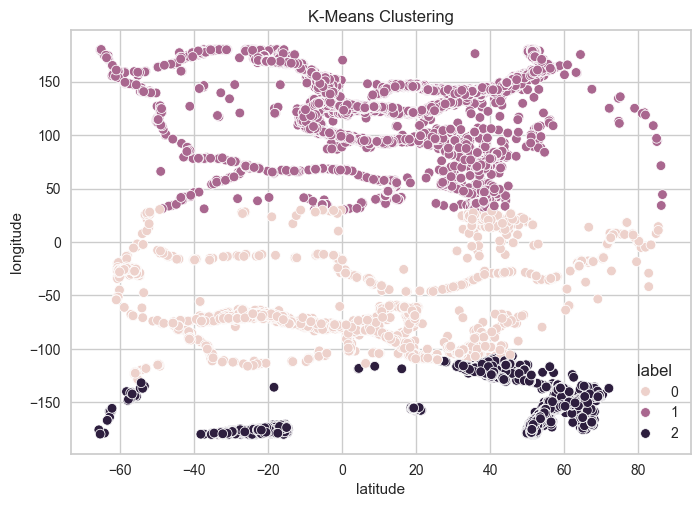

In [12]:
sns.scatterplot(x="latitude", y="longitude", hue="label", data=df_clustered)
plt.title('K-Means Clustering')
plt.show()

### Evaluation

In [13]:
# from sklearn.metrics import rand_score

# rand_skl_kmeans = rand_score(df_clustered['label'], km.labels_)

# print('Rand index')
# print('k-Means: Euclidean (scikit-learn): ',rand_skl_kmeans)
